In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

random_state = 6
np.random.seed(random_state)
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
get_ipython().run_line_magic('matplotlib', 'inline')

# latex parameter
font = {
    'family': 'serif', 
    'serif': ['Computer Modern Roman'],
    'weight' : 'regular',
    'size'   : 18
    }

plt.rc('font', **font)
plt.rc('text', usetex=False)
# plt.style.use('classic')

color_map = 'viridis'

In [3]:
df_train_old = pd.read_csv('train.tsv', sep='\t')
df_test_old = pd.read_csv('test.tsv', sep='\t')

In [4]:
df_train = df_train_old.copy()
df_test = df_test_old.copy()

In [5]:
df_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 679.2 MB


In [6]:
def get_type_wise_memoryinfo(df):
    for dtype in ['float','int','object']:
        selected_dtype = df.select_dtypes(include=[dtype])
        mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
        mean_usage_mb = mean_usage_b / 1024 ** 2
        print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))

get_type_wise_memoryinfo(df_train)

Average memory usage for float columns: 5.66 MB
Average memory usage for int columns: 8.48 MB
Average memory usage for object columns: 126.79 MB


In [186]:
gl_obj = df_train.select_dtypes(include=['object']).copy()
gl_obj.describe()

,name,category_name,brand_name,item_description,root_cat,sub_cat1,sub_cat2
count,1482535,1482535,1482535,1482535,1482535,1482535,1482535
unique,1225273,1288,4810,1281427,11,114,865
top,Bundle,"Women/Athletic Apparel/Pants, Tights, Leggings",missing,No description yet,Women,Athletic Apparel,"Pants, Tights, Leggings"
freq,2232,60177,632682,82489,664385,134383,60177


### Check if both test and train have the same shape

In [7]:
print('Training data shape: {}'.format(df_train.shape))
print('Testing data shape: {}'.format(df_test.shape))

Training data shape: (1482535, 8)
Testing data shape: (693359, 7)


### Check if there are any missing values

In [8]:
print('Is null on train: {}'.format(df_train.isnull().any().any()))
print('Is null on test: {}'.format(df_test.isnull().any().any()))

Is null on train: True
Is null on test: True


In [9]:
def handle_missing_data(dataset):
    dataset['name'].fillna(value='missing', inplace=True)
    dataset['category_name'].fillna(value='missing', inplace=True)
    dataset['brand_name'].fillna(value='missing', inplace=True)
    dataset['item_description'].fillna(value='missing', inplace=True)
    dataset["shipping"] = dataset["shipping"].fillna(0)

In [10]:
handle_missing_data(df_train)
handle_missing_data(df_test)

In [11]:
print('Is null on train: {}'.format(df_train.isnull().any().any()))
print('Is null on test: {}'.format(df_test.isnull().any().any()))

Is null on train: False
Is null on test: False


### Descriptive statistics

In [12]:
df_train.describe()

,train_id,item_condition_id,price,shipping
count,1.482535e+06,1.482535e+06,1.482535e+06,1.482535e+06
mean,7.412670e+05,1.907380e+00,2.673752e+01,4.472744e-01
std,4.279711e+05,9.031586e-01,3.858607e+01,4.972124e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,3.706335e+05,1.000000e+00,1.000000e+01,0.000000e+00
50%,7.412670e+05,2.000000e+00,1.700000e+01,0.000000e+00
75%,1.111900e+06,3.000000e+00,2.900000e+01,1.000000e+00
max,1.482534e+06,5.000000e+00,2.009000e+03,1.000000e+00


In [13]:
df_train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,missing,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,missing,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,missing,44.0,0,Complete with certificate of authenticity


### work on category_name feature

In [14]:
def split_category(text):
    try: 
        arr = text.split('/')
        if len(arr) == 3:
            return arr
        else:
            return ['No Label', 'No Label', 'No Label']
    except: return ['No Label', 'No Label', 'No Label']
     
df_train['root_cat'], df_train['sub_cat1'], df_train['sub_cat2'] = \
zip(*df_train['category_name'].apply(lambda x : split_category(x) ))

df_test['root_cat'], df_test['sub_cat1'], df_test['sub_cat2'] = \
zip(*df_test['category_name'].apply(lambda x : split_category(x) ))

## Copy original data

In [15]:
df_train_new = df_train.copy()
df_test_new = df_test.copy()

## Add brand average price as a new feature

In [16]:
def create_price_feature(df_train, df_test, features, stat):
    for feature in features:
        new_feature = str(feature) +'_'+ str(stat) +'_price'
        price_desc = df_train['price'].groupby(df_train[feature]).describe()
        feature_name, feature_price = zip(*sorted(dict(price_desc[stat]).items(), key=lambda x: x[1]))
        aa = np.column_stack((feature_name, np.log1p(feature_price)))
        df_feature_price = pd.DataFrame(aa, columns=[feature, new_feature])
        
        df_train = pd.merge(df_train, df_feature_price, on=feature, how='left')
        df_test = pd.merge(df_test, df_feature_price, on=feature, how='left')
    
    return df_train, df_test

In [17]:
features = ['brand_name', 'root_cat']
df_train_new, df_test_new = create_price_feature(df_train_new, df_test_new, features, 'mean')
df_train_new, df_test_new = create_price_feature(df_train_new, df_test_new, features, 'max')

In [18]:
df_train_new.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,root_cat,sub_cat1,sub_cat2,brand_name_mean_price,root_cat_mean_price,brand_name_max_price,root_cat_max_price
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,missing,10.0,1,No description yet,Men,Tops,T-shirts,3.097090187926711,3.5749643260905146,7.601402334583733,7.177782416195197
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,3.829103824243,3.5608122159383107,5.017279836814924,7.554858521040676
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,2.7755287216847355,3.3973732660008733,5.288267030694535,7.605890001053122
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,missing,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,3.097090187926711,3.240112671882182,7.601402334583733,6.744059186311348
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,missing,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,3.097090187926711,3.3973732660008733,7.601402334583733,7.605890001053122


In [19]:
print('Is null on train: {}'.format(df_train_new.isnull().any().any()))
print('Is null on train: {}'.format(df_test_new.isnull().any().any()))

Is null on train: False
Is null on train: True


In [20]:
df_test_new['brand_name_mean_price'].fillna(value=0.0, inplace=True)
df_test_new['root_cat_mean_price'].fillna(value=0.0, inplace=True)
df_test_new['brand_name_max_price'].fillna(value=0.0, inplace=True)
df_test_new['root_cat_max_price'].fillna(value=0.0, inplace=True)

In [21]:
print('Is null on train: {}'.format(df_test_new.isnull().any().any()))

Is null on train: False


## Label Encoding

In [22]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

def label_encode(features):
    for feature in features:
        le = LabelEncoder()
        le.fit(np.hstack([df_train_new[feature], df_test_new[feature]]))
        df_train_new[feature] = le.transform(df_train_new[feature])
        df_test_new[feature] = le.transform(df_test_new[feature])
        del le

In [23]:
encoded_features = ['root_cat', 'sub_cat1', 'sub_cat2', 'brand_name']
label_encode(encoded_features)

In [24]:
list(df_train_new)

['train_id',
 'name',
 'item_condition_id',
 'category_name',
 'brand_name',
 'price',
 'shipping',
 'item_description',
 'root_cat',
 'sub_cat1',
 'sub_cat2',
 'brand_name_mean_price',
 'root_cat_mean_price',
 'brand_name_max_price',
 'root_cat_max_price']

## Text processing "name" + "item_description" + "category_name"

In [26]:
import re

def cleanName(text):
    try:
        textProc = text.lower()
        textProc = " ".join(map(str.strip, re.split('(\d+)',textProc)))
        regex = re.compile(u'[^A-Za-z0-9]+')
        textProc = regex.sub(" ", textProc)
        textProc = " ".join(textProc.split())
        
        return textProc
    except: 
        return "name error"

In [27]:
df_train_new['name']               = df_train_new['name'].apply(lambda x: cleanName(x))
df_train_new["item_description"]   = df_train_new["item_description"].apply(lambda x: cleanName(x))
df_train_new['category_name']      = df_train_new['category_name'].apply(lambda x: cleanName(x))

In [28]:
df_test_new['name']               = df_test_new['name'].apply(lambda x: cleanName(x))
df_test_new["item_description"]   = df_test_new["item_description"].apply(lambda x: cleanName(x))
df_test_new['category_name']      = df_test_new['category_name'].apply(lambda x: cleanName(x))

In [29]:
df_train_new.head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,root_cat,sub_cat1,sub_cat2,brand_name_mean_price,root_cat_mean_price,brand_name_max_price,root_cat_max_price
0,0,mlb cincinnati reds t shirt size xl,3,men tops t shirts,5265,10.0,1,no description yet,5,103,770,3.097090187926711,3.5749643260905146,7.601402334583733,7.177782416195197
1,1,razer blackwidow chroma keyboard,3,electronics computers tablets components parts,3889,52.0,0,this keyboard is in great condition and works ...,1,30,215,3.829103824243,3.5608122159383107,5.017279836814924,7.554858521040676
2,2,ava viv blouse,1,women tops blouses blouse,4588,10.0,1,adorable top with a hint of lace and a key hol...,10,104,97,2.7755287216847355,3.3973732660008733,5.288267030694535,7.605890001053122
3,3,leather horse statues,1,home home d cor home d cor accents,5265,35.0,1,new with tags leather horses retail for rm eac...,3,55,407,3.097090187926711,3.240112671882182,7.601402334583733,6.744059186311348
4,4,24 k gold plated rose,1,women jewelry necklaces,5265,44.0,0,complete with certificate of authenticity,10,58,538,3.097090187926711,3.3973732660008733,7.601402334583733,7.605890001053122


## Categories to dummies

In [24]:
cat_features = ['root_cat', 'sub_cat1', 'item_condition_id', 'shipping']
for column in cat_features:
    temp = pd.get_dummies(pd.Series(df_train_new[column]))
    df_train_new = pd.concat([df_train_new,temp],axis=1)
    df_train_new = df_train_new.drop([column],axis=1)

for column in cat_features:
    temp = pd.get_dummies(pd.Series(df_test_new[column]))
    df_test_new = pd.concat([df_test_new,temp],axis=1)
    df_test_new = df_test_new.drop([column],axis=1)

print(df_train_new.values.shape, df_test_new.values.shape)

(1482535, 143) (693359, 142)


## SCALE target variable

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x184cf2198>]], dtype=object)

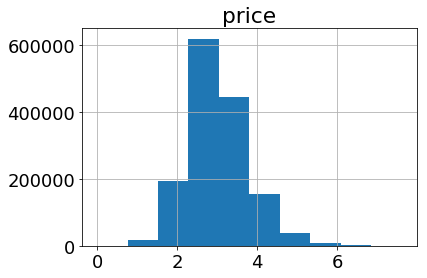

In [25]:
df_train_new["price"] = np.log1p(df_train_new.price)
pd.DataFrame(df_train_new.price).hist()

## Drop columns

In [26]:
Y_train = df_train_new['price'].values

columns_to_drop = ['name', 'category_name', 'item_description']

df_train_new = df_train_new.drop(columns_to_drop, axis = 1)
df_train_new = df_train_new.drop(['price'], axis = 1)
df_train_new = df_train_new.drop(['train_id'], axis = 1)

df_test_new = df_test_new.drop(columns_to_drop, axis = 1)
df_test_new = df_test_new.drop(['test_id'], axis = 1)

### Ensembling

In [27]:
from sklearn.metrics import r2_score

def r2score(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    return r2_score(y_true, y_pred)

def rmsle(y_true, y_pred):
     assert len(y_true) == len(y_pred)
     return np.sqrt(np.mean(np.power(np.log(y_pred + 1) - np.log(y_true + 1), 2)))

In [28]:
from sklearn.model_selection import StratifiedKFold

class Create_ensemble(object):
    def __init__(self, n_splits, base_models):
        self.n_splits = n_splits
        self.base_models = base_models

    def predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)

        folds = list(KFold(n_splits=self.n_splits, shuffle=True, random_state=2016).split(X, y))

        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))
        
        for i, clf in enumerate(self.base_models):
            S_test_i = np.zeros((T.shape[0], self.n_splits))

            for j, (train_idx, valid_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_valid = X[valid_idx]
                y_valid = y[valid_idx]
                clf.fit(X_train, y_train)
                valid_pred = clf.predict(X_valid)
                S_train[valid_idx, i] = valid_pred
                S_test_i[:, j] = clf.predict(T)
                
                print('Model: {}, fold: {}, rmsle: {}'.format(i, j, 1 - r2score(y_valid, valid_pred)))
            print( "\nTraining RMSLE for model {} : {}".format(i, 1 - r2score(y, S_train[:,i])))
            S_test[:, i] = S_test_i.mean(axis=1)
            
        return S_train, S_test

## Lightbm model

In [30]:
# LightGBM params
lgb_params = {}
lgb_params['learning_rate'] = 0.75
lgb_params['n_estimators'] = 200
lgb_params['max_depth'] = 60
lgb_params['num_leaves'] = 50
lgb_params['nthread'] = 4
lgb_params['random_state'] = random_state

lgb_model = LGBMRegressor(**lgb_params)

## Ridge model

In [31]:
from sklearn.linear_model import Ridge
ridge = Ridge(solver='auto', fit_intercept=True, alpha=0.4, max_iter=200, normalize=False, tol=0.01)

In [32]:
df_train_new.shape

(1482535, 138)

In [33]:
lgb_stack = Create_ensemble(n_splits = 10, base_models = [lgb_model, ridge])
X = df_train_new
Y = Y_train
T = df_test_new
lgb_train_pred, lgb_test_pred = lgb_stack.predict(X, Y, T)

Model: 0, fold: 0, rmsle: 0.5384349389378713
Model: 0, fold: 1, rmsle: 0.5433630572278948
Model: 0, fold: 2, rmsle: 0.5380760624020501
Model: 0, fold: 3, rmsle: 0.5420340680940808
Model: 0, fold: 4, rmsle: 0.5388752723939941
Model: 0, fold: 5, rmsle: 0.5349574571029326
Model: 0, fold: 6, rmsle: 0.5399135358614914
Model: 0, fold: 7, rmsle: 0.5371328513187622
Model: 0, fold: 8, rmsle: 0.5426537191617725
Model: 0, fold: 9, rmsle: 0.5363878921091445

Training RMSLE for model 0 : 0.5391714639342451
Model: 1, fold: 0, rmsle: 0.6789844065916032
Model: 1, fold: 1, rmsle: 0.6831214363278085
Model: 1, fold: 2, rmsle: 0.6844211976376292
Model: 1, fold: 3, rmsle: 0.6837675729737981
Model: 1, fold: 4, rmsle: 0.6839416805619367
Model: 1, fold: 5, rmsle: 0.678533572010225
Model: 1, fold: 6, rmsle: 0.6831613050301152
Model: 1, fold: 7, rmsle: 0.6813826712604161
Model: 1, fold: 8, rmsle: 0.6835046413551593
Model: 1, fold: 9, rmsle: 0.6796098054809202

Training RMSLE for model 1 : 0.6820354891426421


## Submission

In [123]:
submission: pd.DataFrame = df_test[['test_id']]
submission['price'] = np.expm1(lgb_test_pred)
submission.to_csv("submission_v1.csv", index=False)

## correlation among the models